# Libraries

In [1]:
import keras
from keras.preprocessing import image as kimage
from keras.applications import mobilenet_v2, densenet
from sklearn.neighbors import KDTree
import joblib
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from time import time
import os

Using TensorFlow backend.


In [2]:
# Imports for face alignment
# How to install:
#    pip install imutils
#    conda install -c conda-forge dlib  
import imutils
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import dlib

In [3]:
import sys
sys.path.insert(1, '../Images')
import utils_2d

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../Images/shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=224)

## Load models

Mobilenet:

In [5]:
mobilenet_model = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', pooling='max', input_shape=(224, 224, 3))

In [6]:
def mobilenet_preprocessing(img):
    if img.shape != (224, 224, 3):
        img = cv.resize(img, (224, 224))
    img = mobilenet_v2.preprocess_input(img)
    return img

Densenet:

In [7]:
densenet_model = densenet.DenseNet121(include_top=False, weights='imagenet', pooling='max', input_shape=(224, 224, 3))

In [8]:
def densenet_preprocessing(img):
    if img.shape != (224, 224, 3):
        img = cv.resize(img, (224, 224))
    img = densenet.preprocess_input(img)
    return img

Model from Part 2:

In [9]:
models_dir = "../Images/models"
model_number = 20
simple_model, labels, simple_prep_fun = utils_2d.load_model(model_number, models_dir)
mask = utils_2d.create_mask()
new_width = 100

def simple_preprocessing(img):
    img = img[:,:,::-1].astype('uint8')
    gray = utils_2d.preprocess_img(img, mask, new_width, detector, fa)
    gray = simple_prep_fun(gray)
    return gray

## Load Features Functions

In [10]:
def compute_features(img, model, preprocessing):
    img = kimage.img_to_array(img)
    img = preprocessing(img)
    if len(img.shape) == 3:
        x = img[np.newaxis, :,:,:]
    else:
        x = img[np.newaxis,:,:,np.newaxis] 
    f = model.predict(x)
    return f.flatten()

In [11]:
# Data loader
def load_data(base_path, model, preprocessing, pics_per_artist=3, color_mode = "rgb",
              target_size=(224,224), file_formats=["png", "jpg"]):

    paths = []
    features = []
    artist_folders = os.listdir(base_path)
    for artist_folder in artist_folders:
        #print(artist_folder)
        artist_path = base_path + "/" + artist_folder
        if os.path.isdir(artist_path):
            for fi,f in enumerate(sorted(os.listdir(artist_path))):
                if (f[-3:] in file_formats) and fi < pics_per_artist:
                    # Memorizza percorso file
                    cur_path = artist_path+"/" + f
                    paths.append(cur_path)
                    # Carica file ed estraine le features
                    # image = kimage.load_img(cur_path, target_size=(224, 224))
                    image = kimage.load_img(cur_path, target_size=(224, 224), color_mode = color_mode)
                    cur_features = compute_features(image, model, preprocessing)
                    features.append(cur_features)

    features = np.array(features)
    return features, paths

# Test on our pictures

In [12]:
path = "../Images/pictures_new/"

In [16]:
%%time
mobilenet_X_train, paths = load_data(path, mobilenet_model, mobilenet_preprocessing)

Wall time: 2.5 s


In [18]:
%%time
densenet_X_train, paths = load_data(path, densenet_model, densenet_preprocessing)

Wall time: 8.98 s


In [20]:
%%time
simple_X_train, paths = load_data(path, simple_model, simple_preprocessing)

Wall time: 2.99 s


## Albero di ricerca

In [21]:
simple_tree = KDTree(simple_X_train)
mobilenet_tree = KDTree(mobilenet_X_train)
densenet_tree = KDTree(densenet_X_train)

In [22]:
def plot_imgs(paths, ind, n_imgs = 10, title = None):
    
    Tot = n_imgs
    Cols = 5
    Rows = Tot // Cols
    Rows += Tot % Cols
    Position = range(1,Tot + 1)
    
    fig = plt.figure(figsize = (15,3 * Rows))
    # fig = plt.figure()
    fig.tight_layout()
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(n_imgs):
        path = paths[ind[0][i]]
        vip_name = path.split("/")[-2]
        img=kimage.load_img(paths[ind[0][i]])
        
        ax = fig.add_subplot(Rows,Cols,Position[i])
        ax.axis('off')
        ax.set_title(f"{i+1}: {vip_name}")
        ax.imshow(img)      # Or whatever you want in the subplot
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

## Query #1

In [23]:
test_img = "../Images/misc_pictures/21.jpg"
img = kimage.load_img(test_img, target_size=(224, 224))

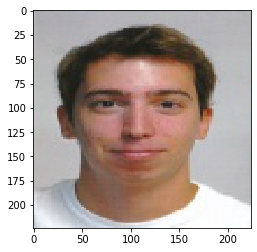

In [24]:
plt.imshow(img)
plt.show()

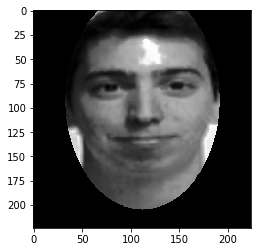

In [25]:
plt.imshow(simple_preprocessing(kimage.img_to_array(img)), cmap="gray")
plt.show()

Trasformo l'immagine:

In [26]:
%time
mobilenet_query_features = compute_features(img, mobilenet_model, mobilenet_preprocessing)

Wall time: 0 ns


In [27]:
%time
densenet_query_features = compute_features(img, densenet_model, densenet_preprocessing)

Wall time: 0 ns


In [28]:
%time
simple_query_features = compute_features(kimage.img_to_array(img), simple_model, simple_preprocessing)

Wall time: 0 ns


Interrogo l'albero di ricerca

In [29]:
%%time
dist1, ind1 = mobilenet_tree.query(mobilenet_query_features.reshape(1, -1), k=10)
dist2, ind2 = densenet_tree.query(densenet_query_features.reshape(1, -1), k=10)
dist3, ind3 = simple_tree.query(simple_query_features.reshape(1, -1), k=10)

Wall time: 0 ns


Which people are more similar to me?

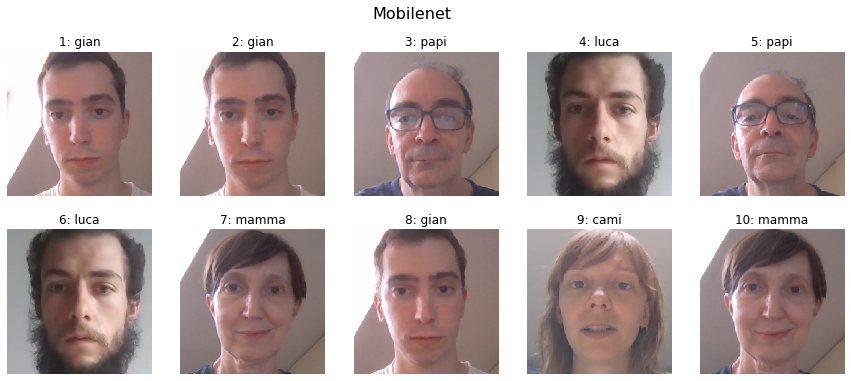

In [33]:
plot_imgs(paths, ind1, title = "Mobilenet")

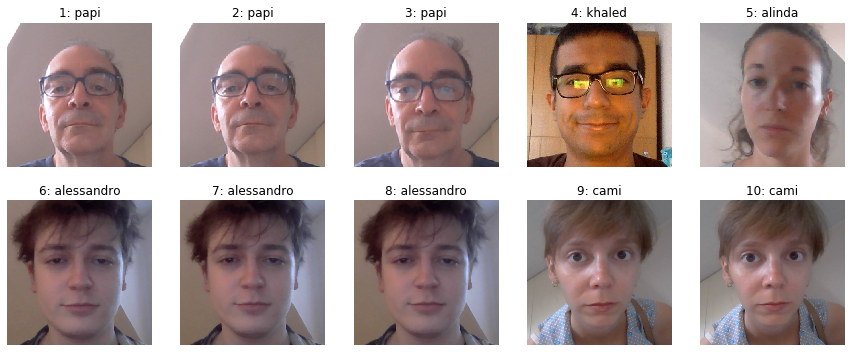

In [31]:
plot_imgs(paths, ind2, title = "Densenet")

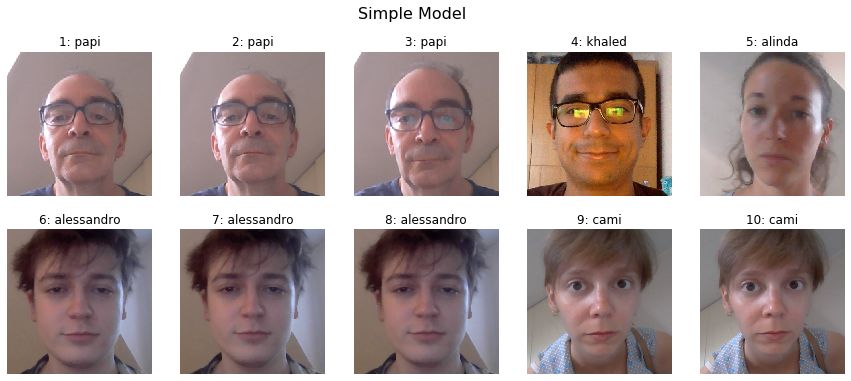

In [34]:
plot_imgs(paths, ind3, title="Simple Model")

## Query #2

In [35]:
img = utils_2d.take_rgb_picture()

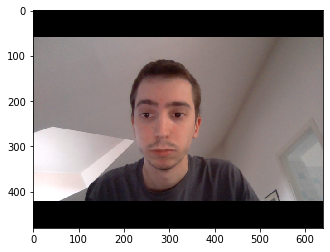

In [36]:
plt.imshow(img)
plt.show()

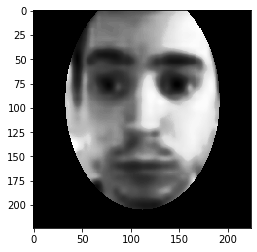

In [37]:
plt.imshow(simple_preprocessing(kimage.img_to_array(img)), cmap="gray")
plt.show()

Trasformo l'immagine:

In [38]:
%time
simple_query_features = compute_features(kimage.img_to_array(img), simple_model, simple_preprocessing)

Wall time: 0 ns


In [39]:
%time
mobilenet_query_features = compute_features(img, mobilenet_model, mobilenet_preprocessing)

Wall time: 0 ns


In [40]:
%time
densenet_query_features = compute_features(img, densenet_model, densenet_preprocessing)

Wall time: 0 ns


Interrogo l'albero di ricerca

In [41]:
%%time

dist1, ind1 = mobilenet_tree.query(mobilenet_query_features.reshape(1, -1), k=10)
dist2, ind2 = densenet_tree.query(densenet_query_features.reshape(1, -1), k=10)
dist3, ind3 = simple_tree.query(simple_query_features.reshape(1, -1), k=10)

Wall time: 0 ns


Which people are more similar to me?

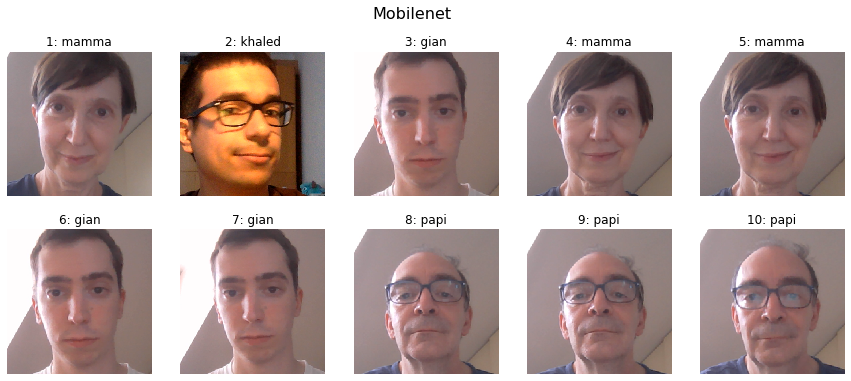

In [42]:
plot_imgs(paths, ind1, title = "Mobilenet")

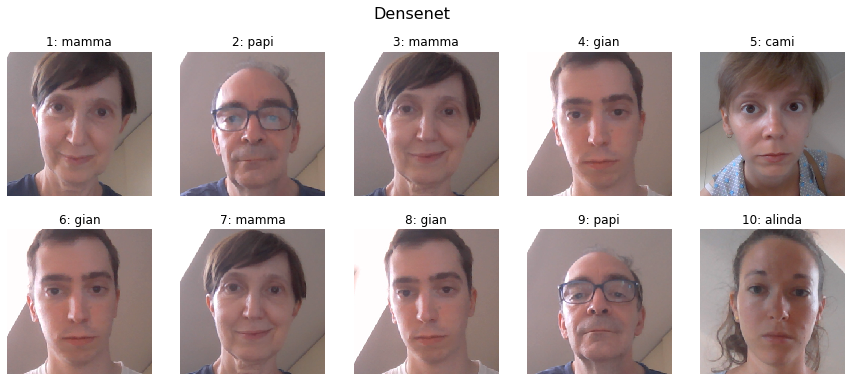

In [43]:
plot_imgs(paths, ind2, title = "Densenet")

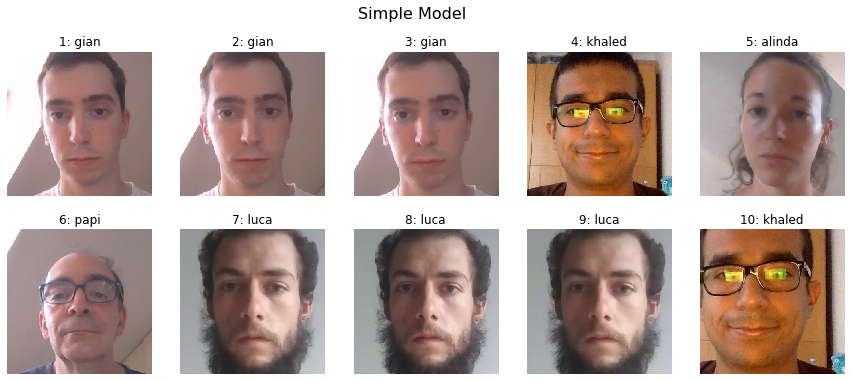

In [44]:
plot_imgs(paths, ind3, title="Simple Model")

# Test on celebrities pictures

In [45]:
path = "celebrities_sample/"

In [46]:
%%time
mobilenet_X_train, paths = load_data(path, mobilenet_model, mobilenet_preprocessing)

Wall time: 2.84 s


In [47]:
%%time
densenet_X_train, paths = load_data(path, densenet_model, densenet_preprocessing)

Wall time: 10.7 s


In [48]:
%%time
simple_X_train, paths = load_data(path, simple_model, simple_preprocessing)

Wall time: 3.61 s


## Albero di ricerca

In [49]:
simple_tree = KDTree(simple_X_train)
mobilenet_tree = KDTree(mobilenet_X_train)
densenet_tree = KDTree(densenet_X_train)

## Query #1

In [50]:
test_img = "../Images/misc_pictures/21.jpg"
img = kimage.load_img(test_img, target_size=(224, 224))

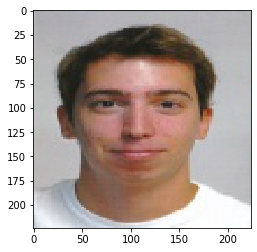

In [51]:
plt.imshow(img)
plt.show()

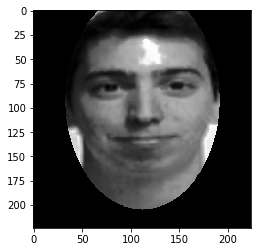

In [52]:
plt.imshow(simple_preprocessing(kimage.img_to_array(img)), cmap="gray")
plt.show()

Trasformo l'immagine:

In [53]:
%time
mobilenet_query_features = compute_features(img, mobilenet_model, mobilenet_preprocessing)

Wall time: 0 ns


In [54]:
%time
densenet_query_features = compute_features(img, densenet_model, densenet_preprocessing)

Wall time: 0 ns


In [55]:
%time
simple_query_features = compute_features(kimage.img_to_array(img), simple_model, simple_preprocessing)

Wall time: 0 ns


Interrogo l'albero di ricerca

In [56]:
%%time
dist1, ind1 = mobilenet_tree.query(mobilenet_query_features.reshape(1, -1), k=10)
dist2, ind2 = densenet_tree.query(densenet_query_features.reshape(1, -1), k=10)
dist3, ind3 = simple_tree.query(simple_query_features.reshape(1, -1), k=10)

Wall time: 1.28 ms


Which people are more similar to me?

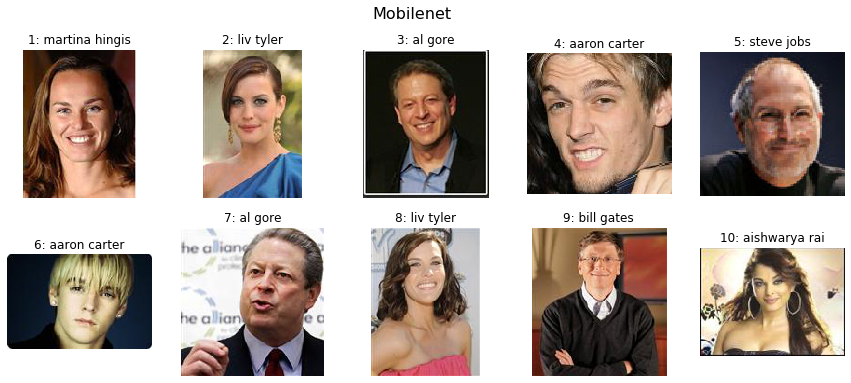

In [57]:
plot_imgs(paths, ind1, title = "Mobilenet")

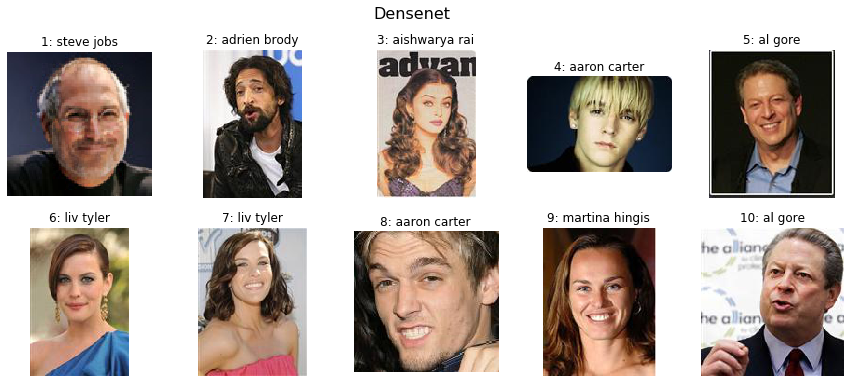

In [58]:
plot_imgs(paths, ind2, title = "Densenet")

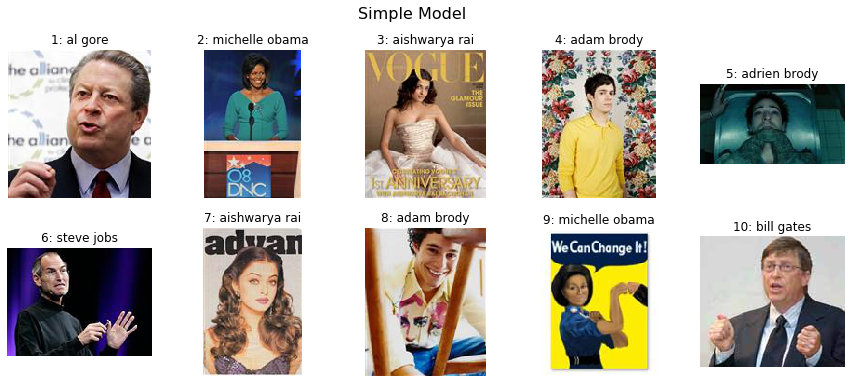

In [59]:
plot_imgs(paths, ind3, title="Simple Model")

## Query #2

In [65]:
img = utils_2d.take_rgb_picture()

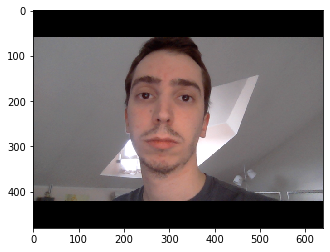

In [66]:
plt.imshow(img)
plt.show()

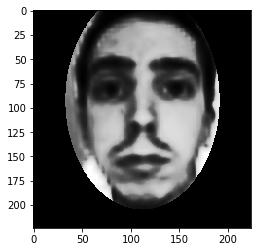

In [67]:
plt.imshow(simple_preprocessing(kimage.img_to_array(img)), cmap="gray")
plt.show()

Trasformo l'immagine:

In [68]:
%time
simple_query_features = compute_features(kimage.img_to_array(img), simple_model, simple_preprocessing)

Wall time: 0 ns


In [69]:
%time
mobilenet_query_features = compute_features(img, mobilenet_model, mobilenet_preprocessing)

Wall time: 0 ns


In [70]:
%time
densenet_query_features = compute_features(img, densenet_model, densenet_preprocessing)

Wall time: 0 ns


Interrogo l'albero di ricerca

In [71]:
%%time

dist1, ind1 = mobilenet_tree.query(mobilenet_query_features.reshape(1, -1), k=10)
dist2, ind2 = densenet_tree.query(densenet_query_features.reshape(1, -1), k=10)
dist3, ind3 = simple_tree.query(simple_query_features.reshape(1, -1), k=10)

Wall time: 0 ns


Which people are more similar to me?

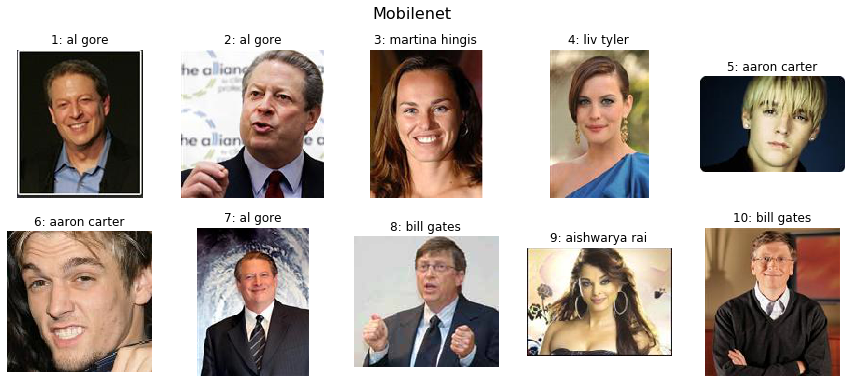

In [72]:
plot_imgs(paths, ind1, title = "Mobilenet")

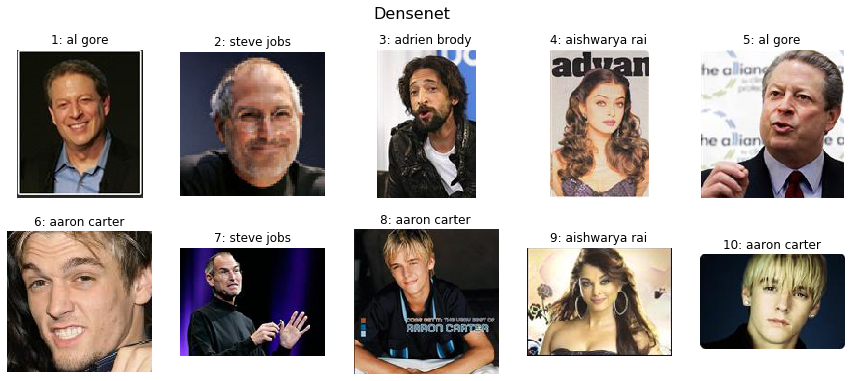

In [73]:
plot_imgs(paths, ind2, title = "Densenet")

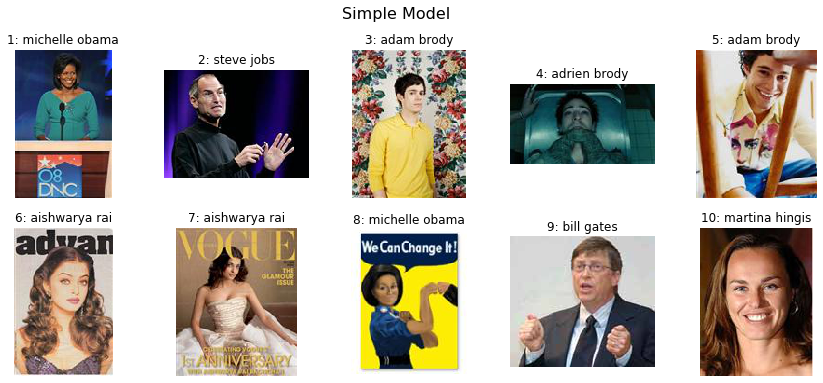

In [74]:
plot_imgs(paths, ind3, title="Simple Model")